## 0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

## 1. Get data:

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f'{image_path} already exist, skipping download.....')
else:
  print(f'{image_path} does not exist, creating one.....')
  image_path.mkdir(parents = True, exist_ok = True)

# Download pizza steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading Pizza, steak and sushi data.....')
  f.write(request.content)

# Unzip Pizza, Steak and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unzipping Pizza, steak and sushi data.....')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one.....
Unzipping Pizza, steak and sushi data.....


##2. Data Preparation and Data Exploration

In [4]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path and return its contents"""
  for dir_path, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}')

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [6]:
# Setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing and image

Random Image path: data/pizza_steak_sushi/train/steak/3245622.jpg
Image class: steak
Image Height: 262
Image width: 512


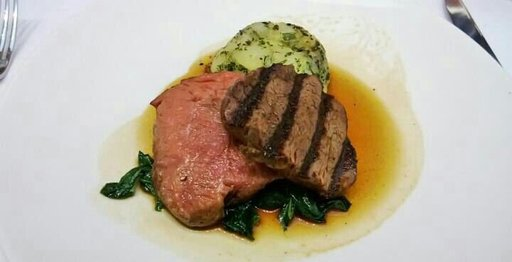

In [7]:
from re import I
import random
from PIL import Image

# random.seed(42)

# 1. Get all image path
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random Image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image width: {img.width}')
img

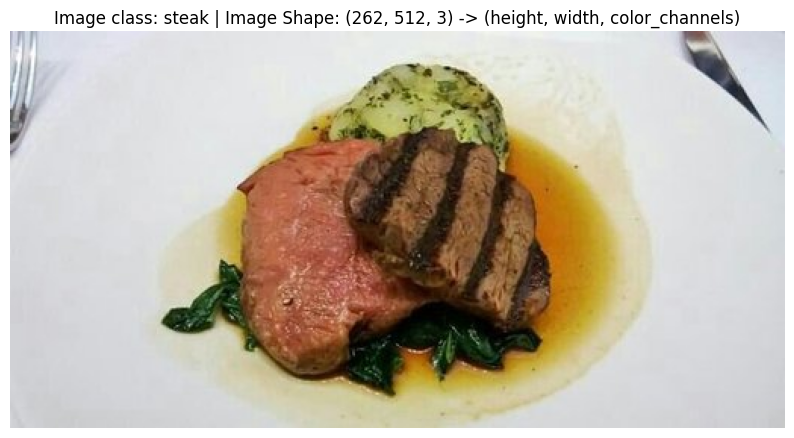

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array  = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image Shape: {img_as_array.shape} -> (height, width, color_channels)')
plt.axis(False);

In [9]:
img_as_array

array([[[171, 170, 188],
        [193, 192, 210],
        [219, 221, 236],
        ...,
        [197, 201, 212],
        [190, 194, 205],
        [185, 189, 200]],

       [[173, 172, 190],
        [192, 191, 209],
        [216, 218, 233],
        ...,
        [206, 210, 221],
        [200, 204, 215],
        [196, 200, 211]],

       [[172, 173, 191],
        [190, 191, 209],
        [213, 214, 232],
        ...,
        [210, 214, 225],
        [207, 211, 222],
        [204, 208, 219]],

       ...,

       [[212, 213, 217],
        [209, 210, 214],
        [207, 208, 212],
        ...,
        [199, 200, 202],
        [199, 201, 200],
        [199, 201, 200]],

       [[211, 212, 216],
        [209, 210, 214],
        [208, 209, 213],
        ...,
        [199, 200, 202],
        [199, 201, 200],
        [200, 202, 201]],

       [[210, 211, 215],
        [209, 210, 214],
        [208, 209, 213],
        ...,
        [198, 199, 201],
        [199, 201, 200],
        [200, 202, 201]]

## 3. Transforming data

1. Turn target images into tensors
2. Turn it into a `torch.utils.data.Dataset` and turn our dataset into `torch.utils.data.DataLoader`. We'll call these `dataset` and `dataloader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

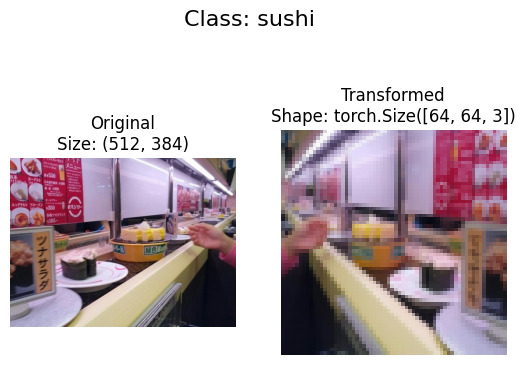

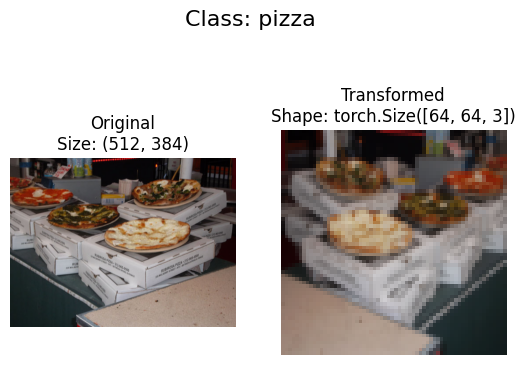

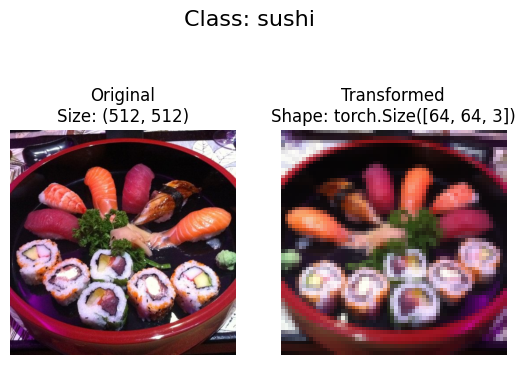

In [13]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = 42):
  """
  Selects the random image from the path of images and loads/transform them plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=3)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # we need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis(False)

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize = 16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n = 3,
                        seed = None)

## 4. Option 1: Loading image data using `ImageFolder`

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # target for the data
                                  target_transform = None) # target for the label
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor:\n {img}')
print(f'Image Shape: {img.shape}')
print(f'Image Datatype: {img.dtype}')
print(f'Image Label: {label}')
print(f'label datatype: {type(label)}')

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Image Permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

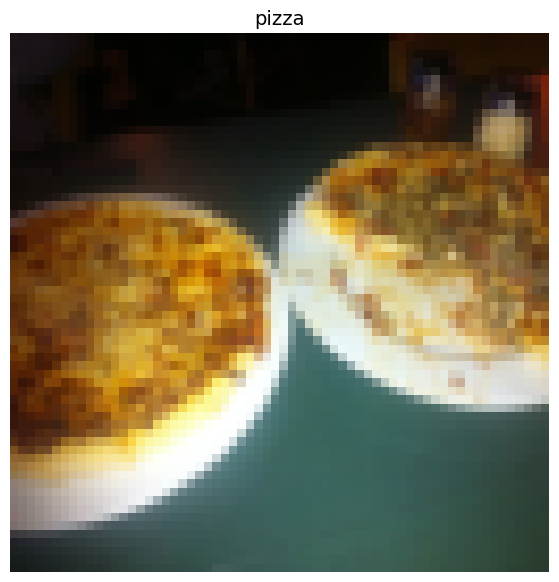

In [19]:
# Rerarrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Original shape: {img.shape} -> [color channels, height, width]')
print(f'Image Permute: {img_permute.shape} -> [height, width, color_channels]')

# Plot the image
plt.figure(figsize = (10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14)

### 4.1 Turn loaded images into `DataLoader`

A DataLoader is going to turn our `Datasets` into iterables and we can customize the `batch_size` images

In [20]:
# Turn train and test into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a117d3c71f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a117d3e4c10>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will be now 1,
print(f'Image Shape: {img.shape} -> [batch size, color_channels, height, width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch size, color_channels, height, width]
Label Shape: torch.Size([1])


## 5. Loading Image with Custom `Dataset`

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a function to get class_names

In [25]:
# Setup path directory
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def findClasses(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the classes folder names in a target directory"""
  # 1. Get the class names by scanning target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f'Couldnt find any classes in {directory}.... Please check file structure')

  # 3. Create a dictionary of index labels
  class_to_idx = {class_names: i for i, class_names in enumerate(classes)}
  return classes, class_to_idx

In [27]:
findClasses(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom dataset to replicate `ImageFolder`

To Create our own custom dataset,

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory and Transform
3. Create several attributes
  * Paths- paths of our images
  * transform
  * classes - a list of the target classes
  * class_to_idx - a dict of target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [28]:
# write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, target_dir: str, transform = None) -> None:
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = findClasses(target_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """
    Opens an image via path and returns it.
    """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    """
    Returns the total number of samples.
    """
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """
    Returns one sample of data, data and label (X, y).
    """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx  # Return data, label (X, y)
    else:
      return img, class_idx # Return untransformed image and label

In [29]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir = train_dir,
                                      transform = train_transforms)
test_data_custom = ImageFolderCustom(target_dir = test_dir,
                                     transform = test_transforms)

In [31]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a117d2522c0>,
 <__main__.ImageFolderCustom at 0x7a117d251630>)

In [32]:
len(train_data), len(train_data_custom)

(225, 225)

In [33]:
len(test_data), len(test_data_custom)

(75, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for quality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.class_to_idx==test_data.class_to_idx)

True
True


###5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other of other parameters such as class_names and how many images to visualize
2. To Prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed to reproducibility
4. Get a list of random sample indexes from the target_dataset
5. Setup a matplotlib plot
6. Loop through random sample images and plot them using matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [37]:
# Create a function to take in datasets
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f'For display purposes, n shouldnt be larger than 10, setting to 10 and removing shape display.')

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  # 5. Setup plot
  plt.figure(figsize = (16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust tensor dim for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot the adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f'Class: {classes[targ_label]}'
      if display_shape:
        title = title + f'\nShape: {targ_image_adjust.shape}'
    plt.title(title)

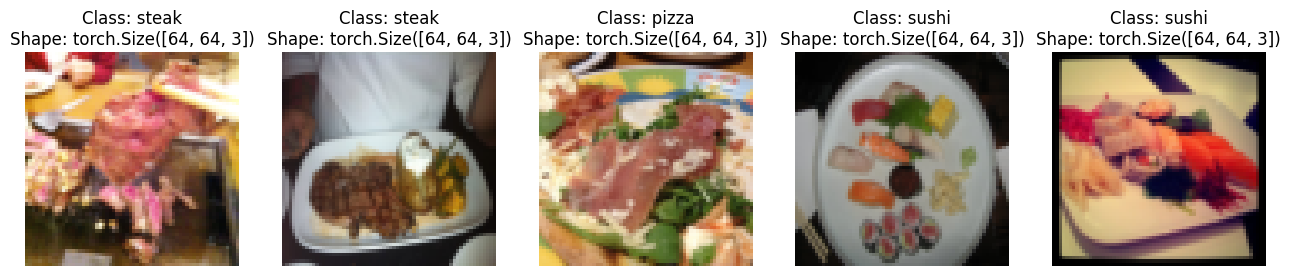

In [38]:
# Display random images from ImageFolder created dataset
display_random_images(train_data, n = 5, classes = class_names,
                      seed = None)

For display purposes, n shouldnt be larger than 10, setting to 10 and removing shape display.


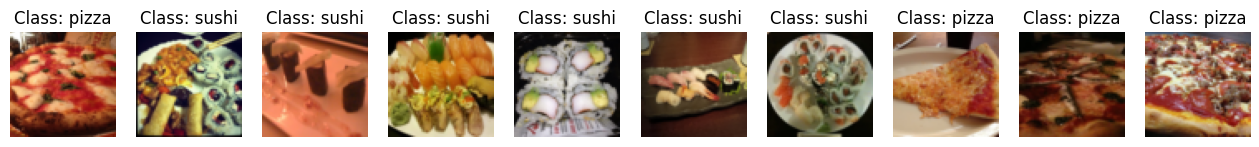

In [39]:
# Display random images from Custom ImageFolder created dataset
display_random_images(train_data_custom, n = 20, classes = class_names,
                     seed = None)

### 5.4 Turn Custom loaded images into `DataLoader`

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers = NUM_WORKERS,
                                     shuffle = True)
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers= NUM_WORKERS,
                                    shuffle = False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a117d002c80>,
 <torch.utils.data.dataloader.DataLoader at 0x7a117d01fa30>)

In [41]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other Forms of transforms (Data Augmentation)

In [42]:
# TrivialAugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

In [43]:
# Get all the image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3196729.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg')]

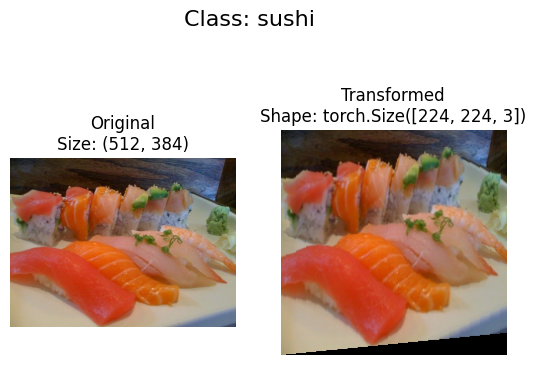

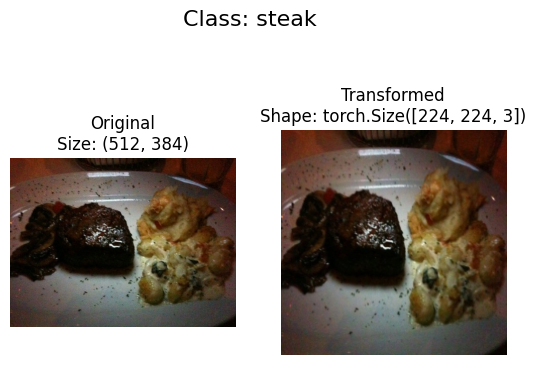

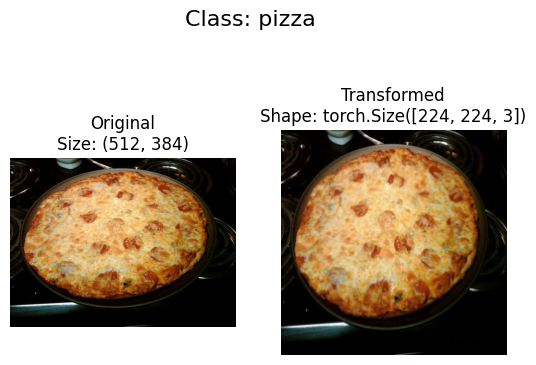

In [44]:
# Plot random images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n = 3,
    seed = None
)

## 7. Model 0: TinyVGG without data augmentation

Replicating TinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for model 0

In [45]:
# Create a simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [46]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 7.2 Create TinyVGG Model class

In [47]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

In [48]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to Test a model)

In [49]:
# Get a single image
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0637, 0.0615, 0.0382]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3364, 0.3357, 0.3279]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [51]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.

* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [52]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [53]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Create a `train()` function to combine `train_step()` and `test_step()`

In [54]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model_0

In [55]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1694 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0993 | train_acc: 0.2891 | test_loss: 1.1338 | test_acc: 0.2083
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1437 | test_acc: 0.1979
Total training time: 5.262 seconds


In [56]:
model_0_results

{'train_loss': [1.107835665345192,
  1.0846430584788322,
  1.115309476852417,
  1.0993012934923172,
  1.0988906472921371],
 'train_acc': [0.2578125, 0.42578125, 0.29296875, 0.2890625, 0.29296875],
 'test_loss': [1.1362075010935466,
  1.1621726353963215,
  1.169418493906657,
  1.133828083674113,
  1.1436519225438435],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.20833333333333334,
  0.19791666666666666]}

### 7.7 Plot the loss curve of model_0

In [57]:
# Get the model_0_results key
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [58]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of result dictionary
  """
  # Get the loss values of results dict(training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy of results dict(training and test)
  accuracy = results['train_acc']
  test_accuracy = results['train_acc']

  # how many epochs
  epochs = range(len(results['train_loss']))

  # Setup a plot
  plt.figure(figsize = (15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = 'train_loss')
  plt.plot(epochs, test_loss, label = 'test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = 'train_acc')
  plt.plot(epochs, test_accuracy, label = 'test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

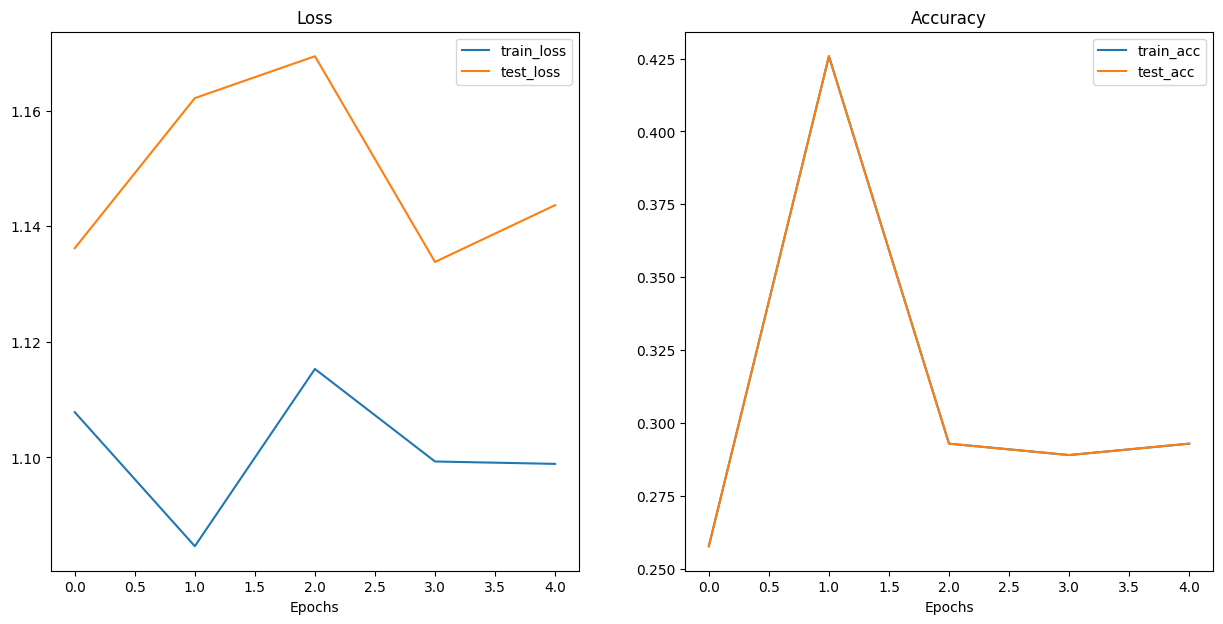

In [59]:
plot_loss_curves(model_0_results)

## 8 Model 1: TinyVGG with Data Augmentation

### 8.1 Create transform with data augmentation

In [60]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])
test_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

### 8.2 Create train and test `dataset` and `DataLoader` with data_augmentation

In [61]:
# Turn our image folder into dataset
train_data_augmented = datasets.ImageFolder(root = train_dir,
                                            transform = train_transform_trivial)
test_data_simple = datasets.ImageFolder(root = test_dir,
                                        transform = test_transform_simple)

### 8.3 Turn our datasets into dataloaders

In [62]:
import os
BATCH_SIZE = 32,
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset = train_data_augmented,
                                        batch_size = 32,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size = 32,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 8.4 Construct and train model_1 by using model architecture but using augmented trained data

In [63]:
# Create model_1 and send it to target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [64]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# epochs
NUM_EPOCHS = 5

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)
                        # device = device).to(device)
end_time = timer()
print(f'Total training time for model_1: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1293 | train_acc: 0.3047 | test_loss: 1.1625 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1483 | test_acc: 0.2604
Total training time for model_1: 4.898 seconds


### 8.5 Plot loss Curves

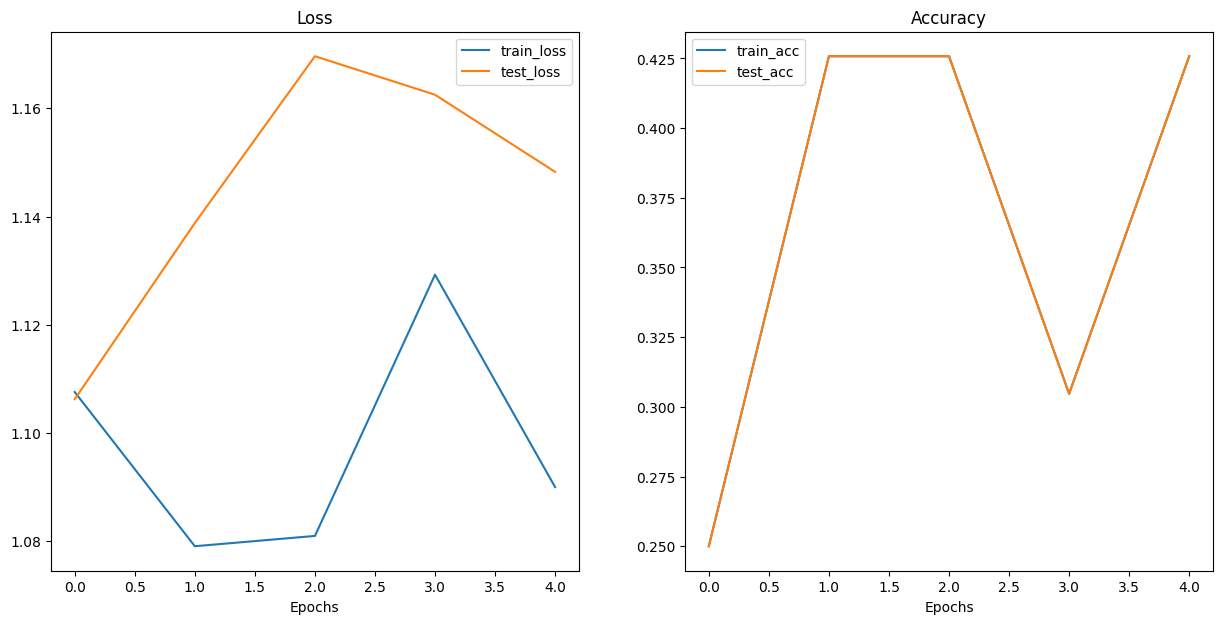

In [65]:
plot_loss_curves(model_1_results)

## 9. Compare Model Results

In [66]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084643,0.425781,1.162173,0.197917
2,1.115309,0.292969,1.169418,0.197917
3,1.099301,0.289062,1.133828,0.208333
4,1.098891,0.292969,1.143652,0.197917


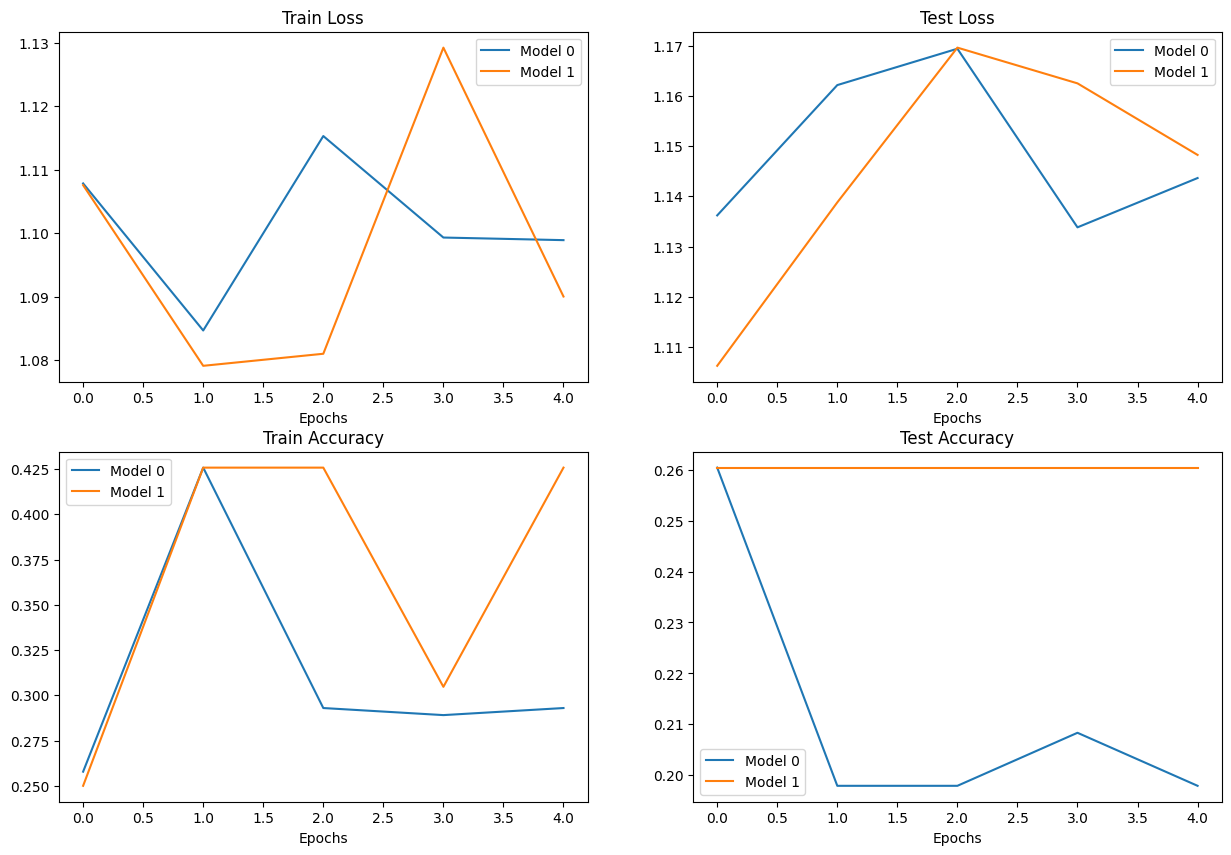

In [67]:
# Setup a plot
plt.figure(figsize = (15,10))

# Get no. of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_loss'], label = 'Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_loss'], label = 'Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend();

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['train_acc'], label = 'Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend();

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label = 'Model 0')
plt.plot(epochs, model_1_df['test_acc'], label = 'Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend();

## 9. Making predictions on custom image

In [70]:
custom_image_path = '/content/pizza.jpg'

In [71]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

In [72]:
# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[206, 201, 204,  ..., 184, 196, 198],
         [207, 202, 203,  ..., 179, 195, 200],
         [203, 200, 201,  ..., 172, 185, 193],
         ...,
         [190, 195, 196,  ..., 205, 163, 197],
         [193, 199, 200,  ..., 189, 184, 236],
         [195, 201, 204,  ..., 174, 209, 255]],

        [[159, 154, 157,  ..., 183, 190, 192],
         [160, 155, 156,  ..., 178, 191, 194],
         [156, 153, 154,  ..., 171, 181, 189],
         ...,
         [183, 189, 192,  ...,  81,  48,  86],
         [186, 192, 196,  ...,  64,  75, 135],
         [188, 194, 197,  ...,  55, 117, 196]],

        [[129, 124, 127,  ..., 179, 192, 194],
         [130, 125, 126,  ..., 174, 190, 196],
         [126, 123, 124,  ..., 167, 180, 188],
         ...,
         [111, 115, 119,  ...,  79,  43,  79],
         [114, 120, 123,  ...,  62,  68, 125],
         [118, 124, 127,  ...,  49, 104, 181]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 1659, 1244])

Custom image dty

### 9.2 Making predictions on a custom image with a trained PyTorch Model

In [73]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: ignored

In [74]:
# Load in custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.8078, 0.7882, 0.8000,  ..., 0.7216, 0.7686, 0.7765],
         [0.8118, 0.7922, 0.7961,  ..., 0.7020, 0.7647, 0.7843],
         [0.7961, 0.7843, 0.7882,  ..., 0.6745, 0.7255, 0.7569],
         ...,
         [0.7451, 0.7647, 0.7686,  ..., 0.8039, 0.6392, 0.7725],
         [0.7569, 0.7804, 0.7843,  ..., 0.7412, 0.7216, 0.9255],
         [0.7647, 0.7882, 0.8000,  ..., 0.6824, 0.8196, 1.0000]],

        [[0.6235, 0.6039, 0.6157,  ..., 0.7176, 0.7451, 0.7529],
         [0.6275, 0.6078, 0.6118,  ..., 0.6980, 0.7490, 0.7608],
         [0.6118, 0.6000, 0.6039,  ..., 0.6706, 0.7098, 0.7412],
         ...,
         [0.7176, 0.7412, 0.7529,  ..., 0.3176, 0.1882, 0.3373],
         [0.7294, 0.7529, 0.7686,  ..., 0.2510, 0.2941, 0.5294],
         [0.7373, 0.7608, 0.7725,  ..., 0.2157, 0.4588, 0.7686]],

        [[0.5059, 0.4863, 0.4980,  ..., 0.7020, 0.7529, 0.7608],
         [0.5098, 0.4902, 0.4941,  ..., 0.6824, 0.7451, 0.7686],
         [0.4941, 0.4824, 0.4863,  ..., 0.6549, 0.7059, 0.

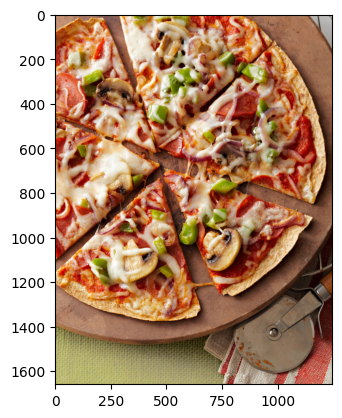

In [75]:
plt.imshow(custom_image.permute(1, 2, 0))

In [76]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: ignored

In [79]:
# Create transform pipeline to resize the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size = (64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shape
print(f'Original Shape: {custom_image.shape}')
print(f'Transformed Shape: {custom_image_transformed.shape}')


Original Shape: torch.Size([3, 1659, 1244])
Transformed Shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


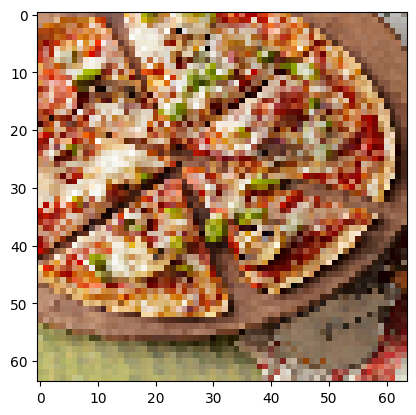

In [80]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [81]:
# This will error no batch size added

model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [82]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [83]:
# Adding batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.1162,  0.0329, -0.1386]], device='cuda:0')

In [84]:
# Convert logits -> Prediction Probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim = 1)
custom_image_pred_probs

tensor([[0.3710, 0.3414, 0.2876]], device='cuda:0')

In [85]:
# Convert predictions probabilities -> Prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim = 1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [86]:
class_names[custom_image_pred_labels]

'pizza'

### 10. Putting Custom image prediction together: building a function

Ideal Outcome:

A function where we pass an image path to and have our model predict on that image and plot the image + prediction.

In [94]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
  """
  Makes a prediction on a target image with a trained model and plots the image and prediction
  """
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel value by 255 to get them between [0,1]
  target_image = target_image / 255.

  # Transform our data if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure modek is on the target device
  model.to(device)

  # Turn on the eval / Inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dim, eg. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the image with extra dimension
    target_image_pred = model(target_image.to(device))

  # Converts logits -> Prediction probabilities
  target_image_pred_prods = torch.softmax(target_image_pred, dim = 1)

  # Convert the prediction probabilities -> prediction labels
  target_image_pred_labels = torch.argmax(target_image_pred_prods, dim = 1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
    title = f'Pred: {class_names[target_image_pred_labels.cpu()]} |  Prob: {target_image_pred_prods.max().cpu():.3f}'
  else:
    title = f'Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}'
  plt.title(title)
  plt.axis(False)

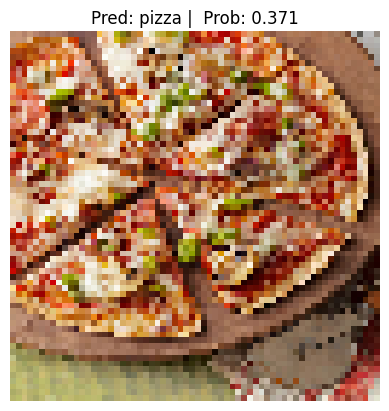

In [95]:
# Pred on our custom Image
pred_and_plot_image(model = model_1,
                    image_path = custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device = device)